In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML


from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

[main] Found existing base CSV: dfs_training/GOOGL_1_base.csv


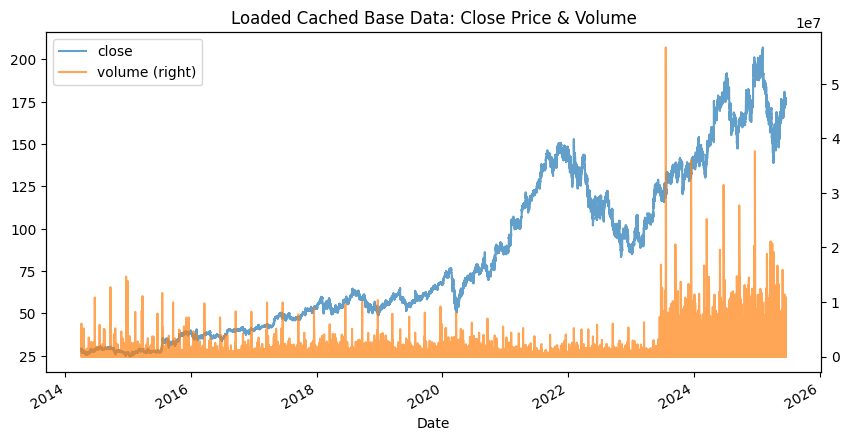

,open,high,low,close,volume,ask,bid
2014-04-03 08:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.617100,173.512900
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.432000,173.328000
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.362000,173.258000
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.332000,173.228000


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 200
n_jobs = 1

base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back, 60))
    regular_start_shifted = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back*2, 60))

    # A) dynamic reference profit (median of all trade profits)
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract daily P&L values
    daily_returns = [
        stats['Strategy Return ($)'] 
        for _, (_, _, stats) in simulation.items()
    ]
    total_pnl = float(np.sum(daily_returns))

    # D) compute average daily P&L (zero‐trade days count as $0)
    trading_days   = df.index.normalize().unique()
    num_trading_days = len(trading_days)
    avg_daily_pnl = total_pnl / num_trading_days if num_trading_days else 0.0

    # E) report & cleanup
    print(f"→ Total P&L across {num_trading_days} days: ${total_pnl:.2f}")
    print(f"→ Average daily P&L         : ${avg_daily_pnl:.4f}\n")

    del simulation, daily_returns
    gc.collect()

    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", [30,60,90,120,150,180]),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 1),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 1),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 1),
        "smooth_win_sig"          : trial.suggest_int("smooth_win_sig", 1, 240),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.01, 0.5),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.05, 0.75),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.05, 0.75),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.75),
    }

    print('---------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-08-02 17:30:33,177] A new study created in RDB with name: no-name-68e03e3a-5495-48e2-be88-7f28e4d76746


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $113.57
→ Average daily P&L         : $0.0403



[I 2025-08-02 17:32:31,365] Trial 0 finished with value: 0.04027198581560284 and parameters: {'look_back': 180, 'min_prof_thr': 0.6271798963227821, 'max_down_prop': 0.7360333945831623, 'gain_tightening_factor': 0.36537229850607855, 'merging_retracement_thr': 0.8056211957204742, 'merging_time_gap_thr': 0.5609049908970618, 'smooth_win_sig': 176, 'pre_entry_decay': 0.12307006053908805, 'short_penalty': 0.5811705207316955, 'trailing_stop_thresh': 0.289784669329755, 'buy_threshold': 0.6642661660744927}. Best is trial 0 with value: 0.04027198581560284.


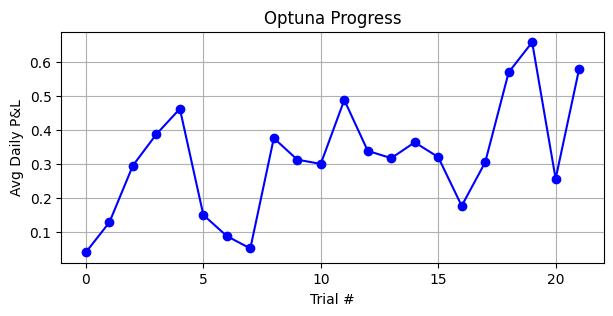

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $362.01
→ Average daily P&L         : $0.1284



[I 2025-08-02 17:34:06,896] Trial 1 finished with value: 0.12837269503546098 and parameters: {'look_back': 60, 'min_prof_thr': 0.746752761478733, 'max_down_prop': 0.3669258112138546, 'gain_tightening_factor': 0.8179097709052737, 'merging_retracement_thr': 0.8745650397039813, 'merging_time_gap_thr': 0.4284145482203816, 'smooth_win_sig': 34, 'pre_entry_decay': 0.3439436150271251, 'short_penalty': 0.541584416174917, 'trailing_stop_thresh': 0.25019077291426556, 'buy_threshold': 0.5002251197320173}. Best is trial 1 with value: 0.12837269503546098.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $832.63
→ Average daily P&L         : $0.2953



[I 2025-08-02 17:35:50,156] Trial 2 finished with value: 0.2952588652482269 and parameters: {'look_back': 120, 'min_prof_thr': 0.6384587469694696, 'max_down_prop': 0.6751228678385944, 'gain_tightening_factor': 0.7288645655318833, 'merging_retracement_thr': 0.2742989905727257, 'merging_time_gap_thr': 0.6083359115283623, 'smooth_win_sig': 217, 'pre_entry_decay': 0.016540901379462833, 'short_penalty': 0.20171934435785366, 'trailing_stop_thresh': 0.07383520383962085, 'buy_threshold': 0.2160248876164697}. Best is trial 2 with value: 0.2952588652482269.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1092.29
→ Average daily P&L         : $0.3873



[I 2025-08-02 17:37:26,905] Trial 3 finished with value: 0.38733510638297874 and parameters: {'look_back': 90, 'min_prof_thr': 0.13902053837124712, 'max_down_prop': 0.3740062950566938, 'gain_tightening_factor': 0.7280442570420598, 'merging_retracement_thr': 0.7132965999495287, 'merging_time_gap_thr': 0.9418862896053, 'smooth_win_sig': 15, 'pre_entry_decay': 0.25287626734225266, 'short_penalty': 0.4522125361656387, 'trailing_stop_thresh': 0.431740251414896, 'buy_threshold': 0.43712988465485664}. Best is trial 3 with value: 0.38733510638297874.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1303.32
→ Average daily P&L         : $0.4622



[I 2025-08-02 17:39:15,401] Trial 4 finished with value: 0.46216950354609926 and parameters: {'look_back': 120, 'min_prof_thr': 0.1916686857346288, 'max_down_prop': 0.15789033520893164, 'gain_tightening_factor': 0.7117394173472364, 'merging_retracement_thr': 0.15433120253277488, 'merging_time_gap_thr': 0.2526128706588551, 'smooth_win_sig': 38, 'pre_entry_decay': 0.3886456887602446, 'short_penalty': 0.232751589056643, 'trailing_stop_thresh': 0.06453596113730971, 'buy_threshold': 0.14482245624734486}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $422.34
→ Average daily P&L         : $0.1498



[I 2025-08-02 17:41:15,595] Trial 5 finished with value: 0.1497645390070922 and parameters: {'look_back': 150, 'min_prof_thr': 0.5544438250430443, 'max_down_prop': 0.42759987763609053, 'gain_tightening_factor': 0.28610316134198505, 'merging_retracement_thr': 0.18921623663402012, 'merging_time_gap_thr': 0.843088027429919, 'smooth_win_sig': 25, 'pre_entry_decay': 0.35457322129418556, 'short_penalty': 0.4856525895105263, 'trailing_stop_thresh': 0.2319743326457564, 'buy_threshold': 0.5465413238782882}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $247.21
→ Average daily P&L         : $0.0877



[I 2025-08-02 17:42:49,229] Trial 6 finished with value: 0.0876613475177305 and parameters: {'look_back': 60, 'min_prof_thr': 0.7754430114046866, 'max_down_prop': 0.4802958858988181, 'gain_tightening_factor': 0.5455383133809558, 'merging_retracement_thr': 0.6081399913267395, 'merging_time_gap_thr': 0.415872387320699, 'smooth_win_sig': 114, 'pre_entry_decay': 0.4554084938681984, 'short_penalty': 0.6189401801126604, 'trailing_stop_thresh': 0.6934224625777357, 'buy_threshold': 0.4425758140259811}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $144.90
→ Average daily P&L         : $0.0514



[I 2025-08-02 17:44:51,913] Trial 7 finished with value: 0.0513840425531915 and parameters: {'look_back': 180, 'min_prof_thr': 0.7665718567705462, 'max_down_prop': 0.47117564529678413, 'gain_tightening_factor': 0.772946525517925, 'merging_retracement_thr': 0.675204249829623, 'merging_time_gap_thr': 0.8883538481654929, 'smooth_win_sig': 145, 'pre_entry_decay': 0.06065445373093453, 'short_penalty': 0.7135689294294372, 'trailing_stop_thresh': 0.10596878830256243, 'buy_threshold': 0.5041783702912935}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1059.64
→ Average daily P&L         : $0.3758



[I 2025-08-02 17:46:43,061] Trial 8 finished with value: 0.3757599290780141 and parameters: {'look_back': 90, 'min_prof_thr': 0.22775777637468908, 'max_down_prop': 0.5242549303592153, 'gain_tightening_factor': 0.11166882190267542, 'merging_retracement_thr': 0.9234562138790043, 'merging_time_gap_thr': 0.26457632214744065, 'smooth_win_sig': 77, 'pre_entry_decay': 0.02944518500358334, 'short_penalty': 0.15789886036935086, 'trailing_stop_thresh': 0.057877802005083606, 'buy_threshold': 0.2554698285018083}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $881.32
→ Average daily P&L         : $0.3125



[I 2025-08-02 17:49:15,421] Trial 9 finished with value: 0.31252340425531916 and parameters: {'look_back': 60, 'min_prof_thr': 0.5243166050568272, 'max_down_prop': 0.18382202044528287, 'gain_tightening_factor': 0.9079041676497206, 'merging_retracement_thr': 0.4085645333688376, 'merging_time_gap_thr': 0.8598240557345436, 'smooth_win_sig': 168, 'pre_entry_decay': 0.17787418247581638, 'short_penalty': 0.08233938310044532, 'trailing_stop_thresh': 0.10369661872083173, 'buy_threshold': 0.12893249002506083}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $846.21
→ Average daily P&L         : $0.3001



[I 2025-08-02 17:51:22,825] Trial 10 finished with value: 0.3000741134751773 and parameters: {'look_back': 120, 'min_prof_thr': 0.3449279882174511, 'max_down_prop': 0.1597399949309321, 'gain_tightening_factor': 0.5816996981683363, 'merging_retracement_thr': 0.10568744301374075, 'merging_time_gap_thr': 0.16706297851596197, 'smooth_win_sig': 76, 'pre_entry_decay': 0.4667509085461954, 'short_penalty': 0.36492460310736385, 'trailing_stop_thresh': 0.5252849791020429, 'buy_threshold': 0.057103406232308}. Best is trial 4 with value: 0.46216950354609926.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1376.46
→ Average daily P&L         : $0.4881



[I 2025-08-02 17:52:45,562] Trial 11 finished with value: 0.48810602836879435 and parameters: {'look_back': 30, 'min_prof_thr': 0.11277754079068242, 'max_down_prop': 0.2695831940296093, 'gain_tightening_factor': 0.6609060026058892, 'merging_retracement_thr': 0.45138529392707677, 'merging_time_gap_thr': 0.6749128248814209, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2713625134622031, 'short_penalty': 0.30276469746506124, 'trailing_stop_thresh': 0.4630842651804625, 'buy_threshold': 0.3471811259466843}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $954.12
→ Average daily P&L         : $0.3383



[I 2025-08-02 17:54:05,175] Trial 12 finished with value: 0.3383397163120567 and parameters: {'look_back': 30, 'min_prof_thr': 0.32989025644952397, 'max_down_prop': 0.10362440552537638, 'gain_tightening_factor': 0.526983215114113, 'merging_retracement_thr': 0.4593975867011363, 'merging_time_gap_thr': 0.7049034351346752, 'smooth_win_sig': 61, 'pre_entry_decay': 0.3425582109614355, 'short_penalty': 0.32742299411677833, 'trailing_stop_thresh': 0.576942388712946, 'buy_threshold': 0.26800126143484926}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $893.73
→ Average daily P&L         : $0.3169



[I 2025-08-02 17:55:22,952] Trial 13 finished with value: 0.31692695035460994 and parameters: {'look_back': 30, 'min_prof_thr': 0.9758621883092812, 'max_down_prop': 0.26929883452462, 'gain_tightening_factor': 0.6325185626638871, 'merging_retracement_thr': 0.3391820617480007, 'merging_time_gap_thr': 0.3677445441952956, 'smooth_win_sig': 4, 'pre_entry_decay': 0.2551391596884731, 'short_penalty': 0.2836737963360327, 'trailing_stop_thresh': 0.383768230464642, 'buy_threshold': 0.3529346457958003}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1025.04
→ Average daily P&L         : $0.3635



[I 2025-08-02 17:57:07,332] Trial 14 finished with value: 0.36348900709219856 and parameters: {'look_back': 120, 'min_prof_thr': 0.10188882369691606, 'max_down_prop': 0.26528356074836773, 'gain_tightening_factor': 0.9928084443365622, 'merging_retracement_thr': 0.5000787254011393, 'merging_time_gap_thr': 0.7173539967286752, 'smooth_win_sig': 43, 'pre_entry_decay': 0.40410644385451105, 'short_penalty': 0.2393935993832584, 'trailing_stop_thresh': 0.4074796471766685, 'buy_threshold': 0.14743206048444815}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $902.52
→ Average daily P&L         : $0.3200



[I 2025-08-02 17:58:26,961] Trial 15 finished with value: 0.32004113475177304 and parameters: {'look_back': 30, 'min_prof_thr': 0.3278840115218898, 'max_down_prop': 0.8776113080050749, 'gain_tightening_factor': 0.4766925869956377, 'merging_retracement_thr': 0.22172149197232421, 'merging_time_gap_thr': 0.1846757037740433, 'smooth_win_sig': 107, 'pre_entry_decay': 0.2572206251635378, 'short_penalty': 0.06059326000444826, 'trailing_stop_thresh': 0.62391327394144, 'buy_threshold': 0.29405057023769876}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $497.92
→ Average daily P&L         : $0.1766



[I 2025-08-02 18:00:18,472] Trial 16 finished with value: 0.17656666666666668 and parameters: {'look_back': 150, 'min_prof_thr': 0.2279050126319499, 'max_down_prop': 0.26389781357198, 'gain_tightening_factor': 0.6588921630709542, 'merging_retracement_thr': 0.35404480980738123, 'merging_time_gap_thr': 0.6678254683700372, 'smooth_win_sig': 55, 'pre_entry_decay': 0.1935982976867236, 'short_penalty': 0.3997016220490924, 'trailing_stop_thresh': 0.49704307183827107, 'buy_threshold': 0.7155644925862404}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $859.11
→ Average daily P&L         : $0.3046



[I 2025-08-02 18:01:56,094] Trial 17 finished with value: 0.3046471631205674 and parameters: {'look_back': 120, 'min_prof_thr': 0.43817322186068486, 'max_down_prop': 0.20572138848402388, 'gain_tightening_factor': 0.42451562325713377, 'merging_retracement_thr': 0.11602540581659443, 'merging_time_gap_thr': 0.49698342600163525, 'smooth_win_sig': 90, 'pre_entry_decay': 0.404359722628554, 'short_penalty': 0.1508736580270552, 'trailing_stop_thresh': 0.32001769253716744, 'buy_threshold': 0.3521249980267775}. Best is trial 11 with value: 0.48810602836879435.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1605.31
→ Average daily P&L         : $0.5693



[I 2025-08-02 18:03:17,416] Trial 18 finished with value: 0.5692581560283688 and parameters: {'look_back': 30, 'min_prof_thr': 0.23417796335601623, 'max_down_prop': 0.577473323405463, 'gain_tightening_factor': 0.8796857675122106, 'merging_retracement_thr': 0.5826919253331637, 'merging_time_gap_thr': 0.10255851108903752, 'smooth_win_sig': 6, 'pre_entry_decay': 0.2896312244096094, 'short_penalty': 0.29231191121129146, 'trailing_stop_thresh': 0.18026003985532463, 'buy_threshold': 0.16177520606040866}. Best is trial 18 with value: 0.5692581560283688.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1855.32
→ Average daily P&L         : $0.6579



[I 2025-08-02 18:04:36,578] Trial 19 finished with value: 0.6579152482269504 and parameters: {'look_back': 30, 'min_prof_thr': 0.4001413602642434, 'max_down_prop': 0.5765974219750768, 'gain_tightening_factor': 0.8825898807054903, 'merging_retracement_thr': 0.5615155352544813, 'merging_time_gap_thr': 0.10184088683099278, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2939174960050699, 'short_penalty': 0.31106424060481586, 'trailing_stop_thresh': 0.17136130944983824, 'buy_threshold': 0.06460878744535105}. Best is trial 19 with value: 0.6579152482269504.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $722.66
→ Average daily P&L         : $0.2563



[I 2025-08-02 18:05:59,455] Trial 20 finished with value: 0.25626170212765953 and parameters: {'look_back': 30, 'min_prof_thr': 0.4260590670169586, 'max_down_prop': 0.6101254617070826, 'gain_tightening_factor': 0.8626671191502272, 'merging_retracement_thr': 0.5637504460598148, 'merging_time_gap_thr': 0.11078429276270478, 'smooth_win_sig': 227, 'pre_entry_decay': 0.3080970774691733, 'short_penalty': 0.4493088116246421, 'trailing_stop_thresh': 0.16118898402697418, 'buy_threshold': 0.06498283199473957}. Best is trial 19 with value: 0.6579152482269504.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1633.31
→ Average daily P&L         : $0.5792



[I 2025-08-02 18:07:39,041] Trial 21 finished with value: 0.5791886524822696 and parameters: {'look_back': 30, 'min_prof_thr': 0.2522248490868655, 'max_down_prop': 0.6036254238933626, 'gain_tightening_factor': 0.9777705381246926, 'merging_retracement_thr': 0.6492772859009993, 'merging_time_gap_thr': 0.25319908191051294, 'smooth_win_sig': 4, 'pre_entry_decay': 0.2968787005492643, 'short_penalty': 0.29904340616589603, 'trailing_stop_thresh': 0.16979935244937006, 'buy_threshold': 0.1926146949045623}. Best is trial 19 with value: 0.6579152482269504.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial=True,
)

# Final plot
fig = plot_optimization_history(study)
fig.set_size_inches(8, 4)
fig.axes[0].set_title("Optuna Optimization History")
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars.json"
file_path  = os.path.join(params.optuna_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
